In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
import absorption_line_vel as vel
from absorption_line_vel import SpectrumSN_Lines, AbsorbLine

# read spec data
z = 0.0307
spec = '../../spectroscopy/SN2020jgb/host_20220331_Keck2_corrected.ascii'
Spec1 = SpectrumSN_Lines(spec, 0)
Spec = SpectrumSN_Lines(spec, 0)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = '25'
mpl.rcParams['xtick.labelsize'] = '20'
mpl.rcParams['ytick.labelsize'] = '20'

Emission lines from http://astronomy.nmsu.edu/drewski/tableofemissionlines.html

# 20220331_Keck2

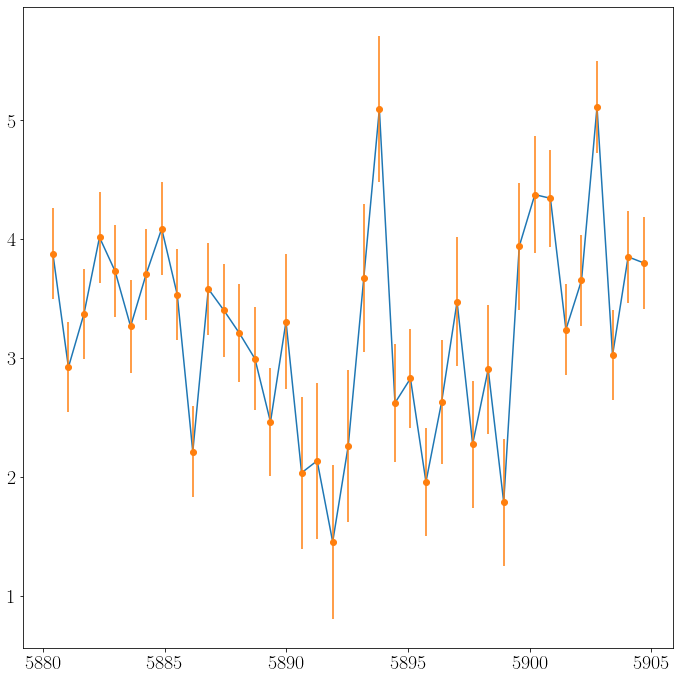

In [4]:
ax = Spec.plot_line_region(5880, 5905)

In [5]:
Spec.add_line('NaI_5896', 5880, 5905, lines=[5889.950, 5895.924], rel_strength=[2, 1])

LS estimation:
Velocity 1: 52 km/s
Normalize factor = 1.424


  9%|███████████████▍                                                                                                                                                           | 4500/50000 [00:32<05:29, 138.07it/s]

MCMC results:
Velocity 1: 50 pm 35 km/s


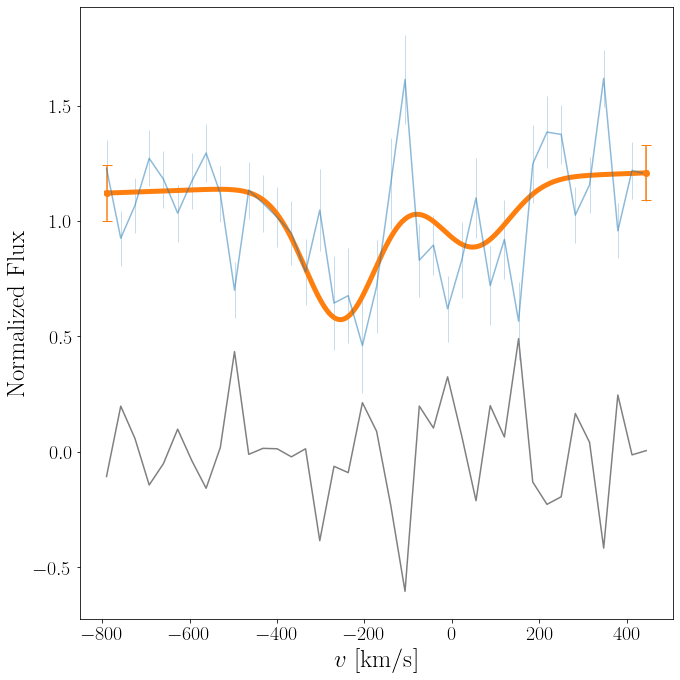

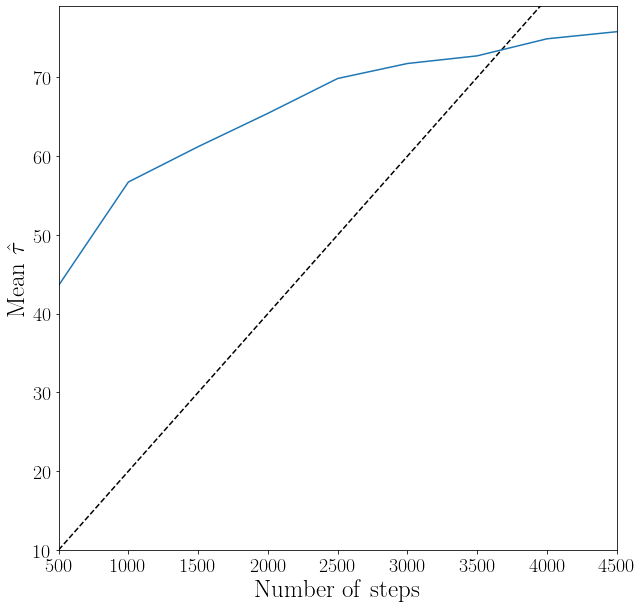

In [6]:
'''sampler = Spec.line['NaI_5896'].MCMC_sampler(initial=[1, 1, -100, 3, -5],
                                             normalize_unc=False,
                                             max_nsteps=1000)'''
Spec.line['NaI_5896'].LS_estimator(guess=(1, 1, 0, 8, -5))
sampler = Spec.line['NaI_5896'].MCMC_sampler(
    vel_flat=[-350, 350],
    #var_max=1e4,
    initial=[1, 1, 0, 8, -5],
    normalize_unc='LS',
    #Plot_mcmc=True,
    Plot_tau=True)

In [7]:
sample = sampler.get_chain(discard=700, flat=True, thin=1)
logprob = sampler.get_log_prob(discard=700, flat=True, thin=1)

Na = Spec.line['NaI_5896']
ratio = 2 / (Na.red_vel - Na.blue_vel) / (Na.red_fl[0]+Na.blue_fl[0])*\
            (Na.wv_line[-1] - Na.wv_line[0]) * np.sum(Na.rel_strength) * 1000
sig = np.exp(sample[:, -2] / 2)
EW = sample[:, -1] * -ratio
hist, bin_edges = np.histogram(EW, bins=100, density=True)
bins = (bin_edges[1:] + bin_edges[:-1]) / 2
width = bin_edges[1] - bin_edges[0]
arg = np.argsort(hist)

cred = 0.68  # credible region
dens_thres = np.inf
j = 0
while cred > 0:
    cred -= width * hist[arg[-1 - j]]
    dens_thres = hist[arg][-1 - j]
    j += 1
interval68 = bins[hist > dens_thres]

cred = 0.95-0.68  # credible region
while cred > 0:
    cred -= width * hist[arg[-1 - j]]
    dens_thres = hist[arg][-1 - j]
    j += 1
interval95 = bins[hist > dens_thres]

p1 = interval68[-1]
p2 = interval95[-1]

In [8]:
EBV1 = lambda EW: (2.47 * EW / 1000 - 1.76)
EBV2 = lambda EW: (2.16 * EW / 1000 - 1.91)
EBV = lambda EW: (1.17 * EW / 1000 - 1.85)

In [9]:
'''import corner
paramsNames = [
    r'$\mathrm{Blue\ edge\ flux}$', r'$\mathrm{Red\ edge\ flux}$', r'$v$',
    r'$\ln(\sigma^2)$', r'$\mathrm{EW}$'
]
chain = sample.copy()
chain[:, -1] = -ratio * chain[:, -1]
fig = corner.corner(chain[::7],
                    labels=paramsNames,
                    quantiles=[0.16, 0.50, 0.84],
                    show_titles=True)'''

"import corner\nparamsNames = [\n    r'$\\mathrm{Blue\\ edge\\ flux}$', r'$\\mathrm{Red\\ edge\\ flux}$', r'$v$',\n    r'$\\ln(\\sigma^2)$', r'$\\mathrm{EW}$'\n]\nchain = sample.copy()\nchain[:, -1] = -ratio * chain[:, -1]\nfig = corner.corner(chain[::7],\n                    labels=paramsNames,\n                    quantiles=[0.16, 0.50, 0.84],\n                    show_titles=True)"

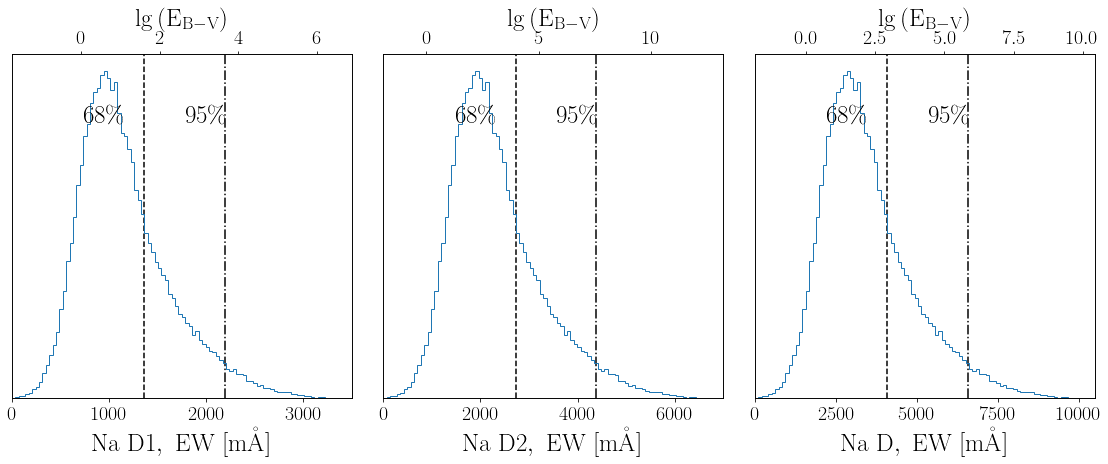

In [10]:
f, ax = plt.subplots(1, 3, figsize=(16, 7), sharey=True)
Range = 3500
ax[0].axvline(p1 / 3, color='k', linestyle='--')
ax[0].axvline(p2 / 3, color='k', linestyle='-.')
ax[0].text(p1 / 3 / Range / 3 + 0.08,
           0.8,
           r'$68\%$',
           transform=ax[0].transAxes)
ax[0].text(p2 / 3 / Range / 3 + 0.3,
           0.8,
           r'$95\%$',
           transform=ax[0].transAxes)
ax[0].hist(EW / 3, histtype='step', bins=100, range=[0, Range])
ax[0].set_xlabel(r'$\mathrm{Na\ D1,\ EW}\ [\mathrm{m\mathring{A}}]$')
ax02 = ax[0].twiny()
ax02.set_xlabel(r'$\lg\left(\mathrm{E_{\mathrm{B}-\mathrm{V}}}\right)$')
ax[0].set_xlim(0, Range)
ax02.set_xlim(EBV1(0), EBV1(Range))

ax[1].axvline(p1 * 2 / 3, color='k', linestyle='--')
ax[1].axvline(p2 * 2 / 3, color='k', linestyle='-.')
ax[1].text(p1 / 3 / Range / 3 + 0.08,
           0.8,
           r'$68\%$',
           transform=ax[1].transAxes)
ax[1].text(p2 / 3 / Range / 3 + 0.3,
           0.8,
           r'$95\%$',
           transform=ax[1].transAxes)
ax[1].hist(EW * 2 / 3, histtype='step', bins=100, range=[0, Range * 2])
ax[1].set_xlabel(r'$\mathrm{Na\ D2,\ EW}\ [\mathrm{m\mathring{A}}]$')
ax12 = ax[1].twiny()
ax12.set_xlabel(r'$\lg\left(\mathrm{E_{\mathrm{B}-\mathrm{V}}}\right)$')
ax[1].set_xlim(0, Range * 2)
ax12.set_xlim(EBV2(0), EBV2(Range * 2))

ax[2].axvline(p1, color='k', linestyle='--')
ax[2].axvline(p2, color='k', linestyle='-.')
ax[2].text(p1 / 3 / Range / 3 + 0.08,
           0.8,
           r'$68\%$',
           transform=ax[2].transAxes)
ax[2].text(p2 / 3 / Range / 3 + 0.3,
           0.8,
           r'$95\%$',
           transform=ax[2].transAxes)
ax[2].hist(EW, histtype='step', bins=100, range=[0, Range * 3])
ax[2].set_xlabel(r'$\mathrm{Na\ D,\ EW}\ [\mathrm{m\mathring{A}}]$')
ax22 = ax[2].twiny()
ax22.set_xlabel(r'$\lg\left(\mathrm{E_{\mathrm{B}-\mathrm{V}}}\right)$')
ax[2].set_xlim(0, Range * 3)
ax22.set_xlim(EBV(0), EBV(Range * 3))

ax[0].set_yticks([])
f.tight_layout()

## H$\alpha$

<AxesSubplot:>

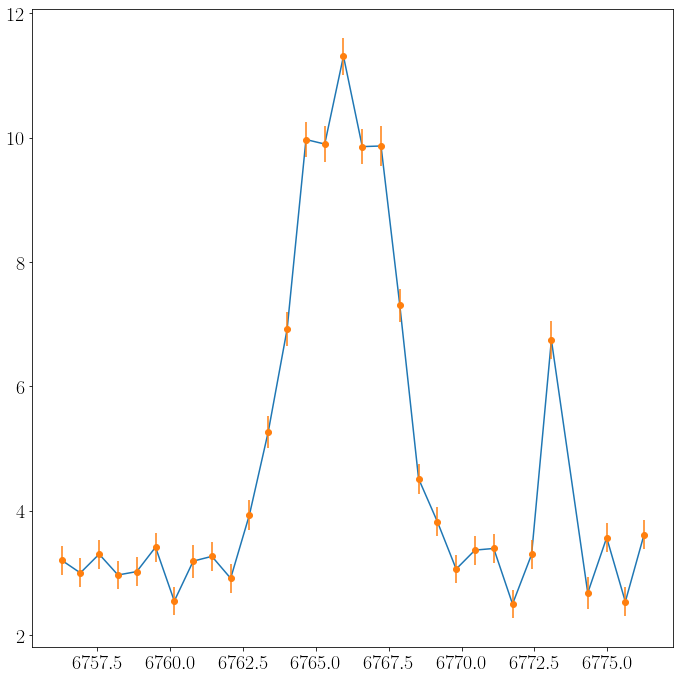

In [11]:
Spec1.plot_line_region(6555*(1+z), 6575*(1+z))

In [18]:
Spec1.add_line('Halpha',
               6560*(1+z),
               6570*(1+z),
               lines=[[6562.819]],
               rel_strength=[[]])
Spec1.line['Halpha'].LS_estimator(guess=(1, 1, 9000, 10, 100))

LS estimation:
Velocity 1: 9133 km/s


/Users/chang/Desktop/SNIa/SN2020jgb/rv/SN2020jgb/../absorption_line_vel.py:160: UserWarning: <=5 points within the wavelength range!
  warnings.warn(


Normalize factor = 1.822


 12%|█████████████████████▍                                                                                                                                                     | 2500/20000 [00:15<01:46, 164.86it/s]


MCMC results:
Velocity 1: 9133 pm 3 km/s


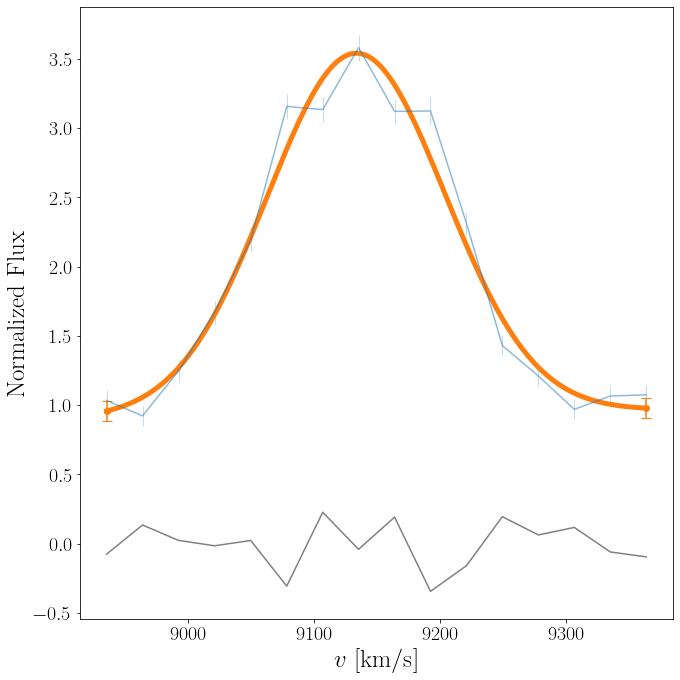

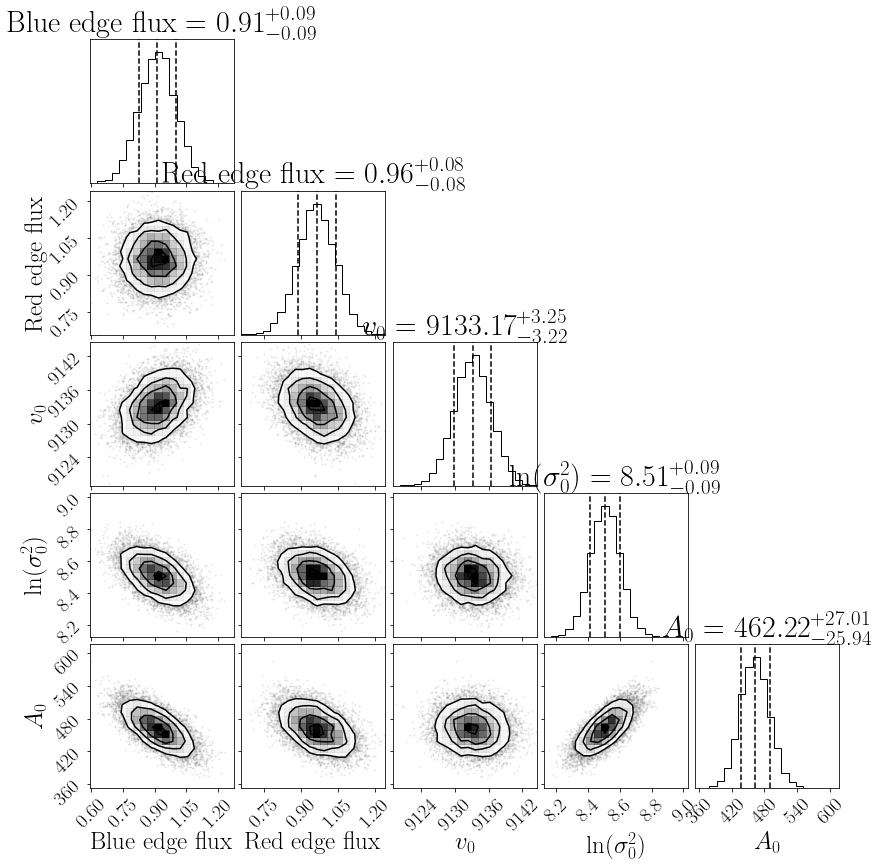

In [19]:
Spec1.line['Halpha'].MCMC_sampler(
    vel_flat=[8500, 9500],
    initial=[],
    normalize_unc='LS',
    Plot_mcmc=True,
    max_nsteps=20000,
    Plot_tau=False)

In [20]:
Spec1.line['Halpha'].EW, Spec1.line['Halpha'].sig_EW

(-19.56859522777092, 1.0132036734789136)

## [N ii]

<AxesSubplot:>

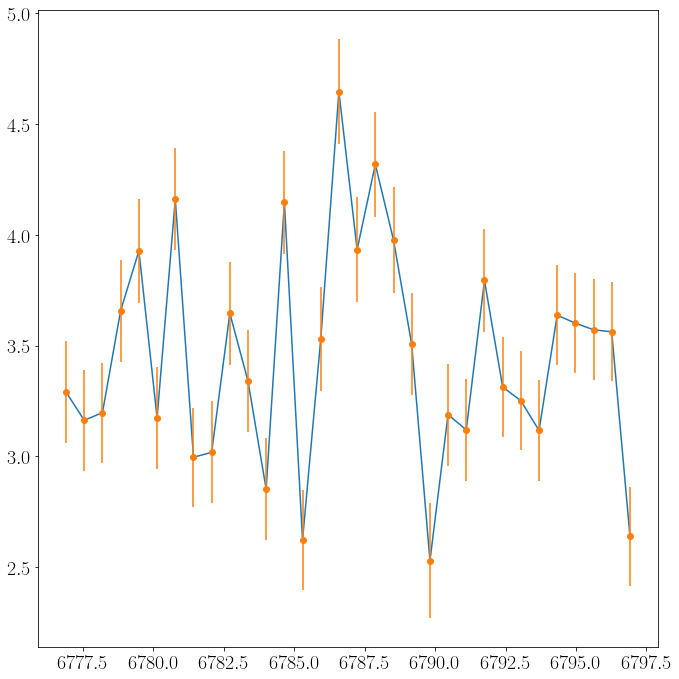

In [21]:
Spec1.plot_line_region(6575*(1+z), 6595*(1+z))

In [22]:
Spec1.add_line('Nii',
               6575*(1+z),
               6595*(1+z),
               lines=[[6583.460]],
               rel_strength=[[]])
Spec1.line['Nii'].LS_estimator(guess=(1, 1, 9000, 8, 100))

LS estimation:
Velocity 1: 8074 km/s


Normalize factor = 2.075


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 9000/10000 [00:54<00:06, 164.86it/s]

MCMC results:
Velocity 1: 9135 pm 40 km/s


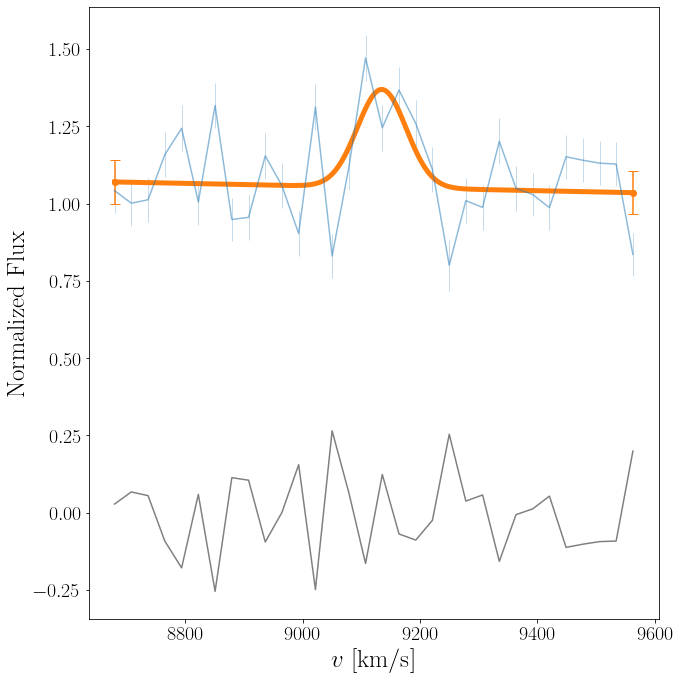

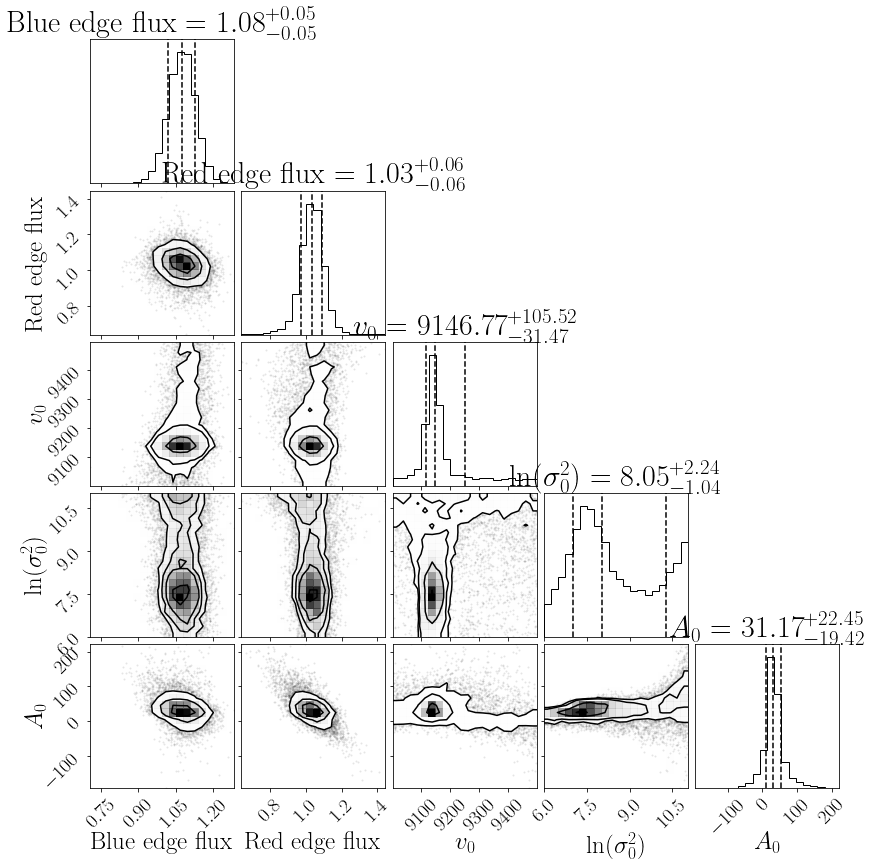

In [45]:
Spec1.line['Nii'].MCMC_sampler(
    vel_flat=[9000, 9500],
    var_max=1e5,
    initial=[1, 1, 9100, 8, 100],
    normalize_unc='LS',
    Plot_mcmc=True,
    max_nsteps=10000,
    Plot_tau=False)

In [46]:
Spec1.line['Nii'].EW, Spec1.line['Nii'].sig_EW

(-1.4550198177429174, 0.6453168215998836)

In [47]:
result = Spec1.line['Nii'].EW / Spec1.line['Halpha'].EW
sig = ((Spec1.line['Nii'].sig_EW / Spec1.line['Nii'].EW)**2 +
       (Spec1.line['Halpha'].sig_EW / Spec1.line['Halpha'].EW)**2) * result
print('lg [Nii]/Halpha = {:.2f}+{:.2f}-{:.2f}'.format(
    np.log10(result), np.log10(1 + sig / result), -np.log10(1 - sig / result)))

lg [Nii]/Halpha = -1.13+0.08-0.10


## H$\beta$

<AxesSubplot:>

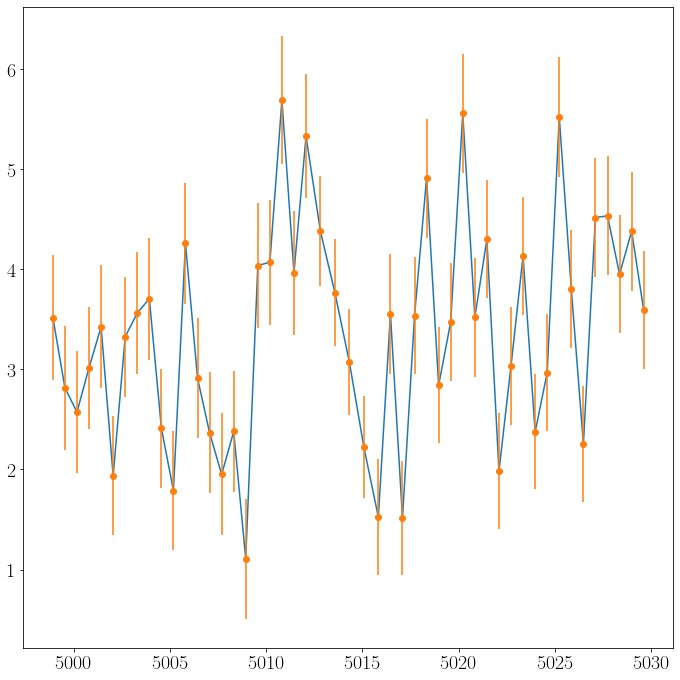

In [29]:
Spec1.plot_line_region(4850*(1+z), 4880*(1+z))

In [30]:
Spec1.add_line('Hbeta',
               4853*(1+z),
               4873*(1+z),
               lines=[[4861.333]],
               rel_strength=[[]])
Spec1.line['Hbeta'].LS_estimator(guess=(1, 1, 9000, 8, 100))

LS estimation:
Velocity 1: 9122 km/s


Normalize factor = 1.673


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 17000/20000 [01:49<00:19, 154.89it/s]

MCMC results:
Velocity 1: 9130 pm 60 km/s


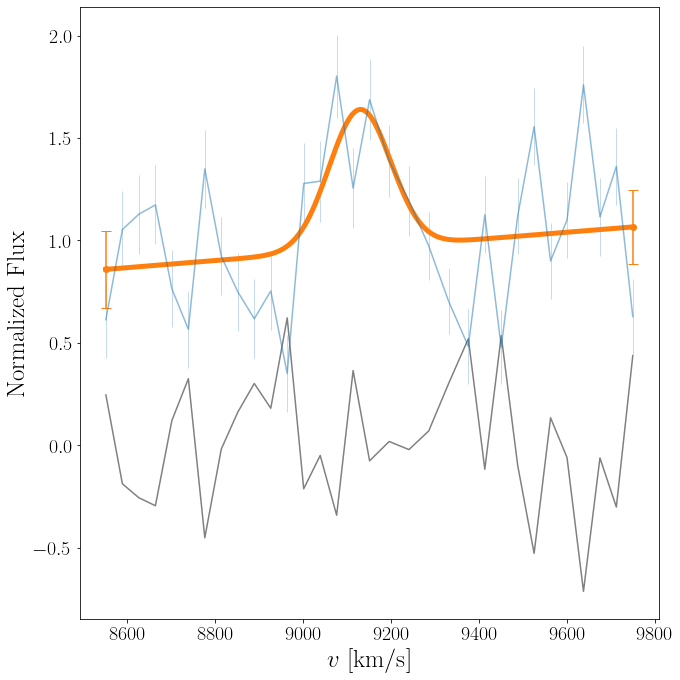

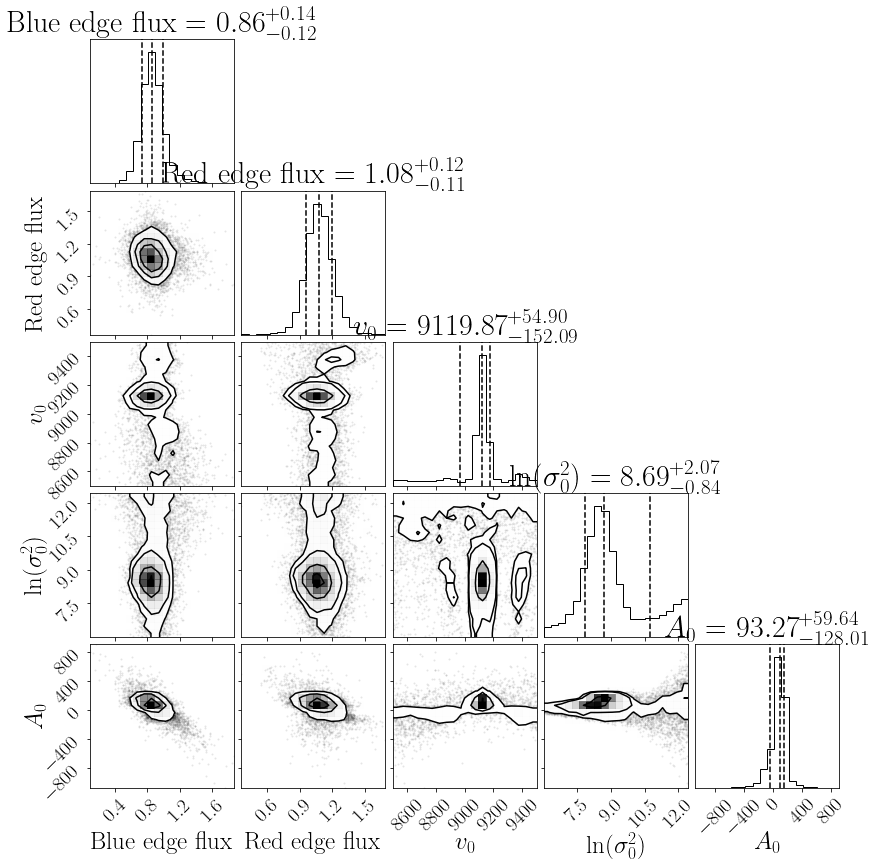

In [31]:
Spec1.line['Hbeta'].MCMC_sampler(
    vel_flat=[8500, 9500],
    var_max=1e6,
    initial=[],
    normalize_unc='LS',
    Plot_mcmc=True,
    max_nsteps=20000,
    Plot_tau=False)

In [32]:
Spec1.line['Hbeta'].EW, Spec1.line['Hbeta'].sig_EW

(-3.899048300325177, 1.492906565636036)

## [O iii]

<AxesSubplot:>

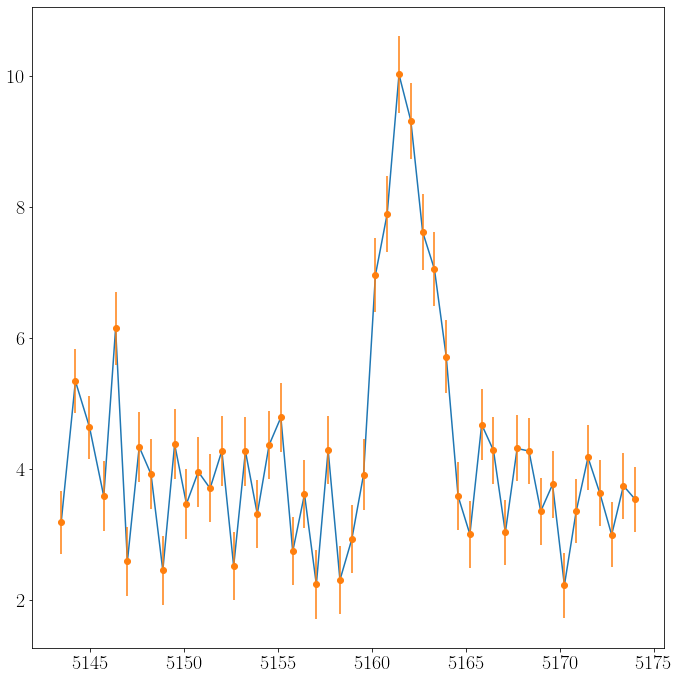

In [33]:
Spec1.plot_line_region(4990*(1+z), 5020*(1+z))

In [34]:
Spec1.add_line('Oiii',
               5000*(1+z),
               5015*(1+z),
               lines=[[5006.843]],
               rel_strength=[[]])
Spec1.line['Oiii'].LS_estimator(guess=(1, 1, 9000, 8, 100))

LS estimation:
Velocity 1: 9134 km/s


/Users/chang/Desktop/SNIa/SN2020jgb/rv/SN2020jgb/../absorption_line_vel.py:160: UserWarning: <=5 points within the wavelength range!
  warnings.warn(


Normalize factor = 1.458


 15%|█████████████████████████▋                                                                                                                                                 | 3000/20000 [00:18<01:44, 163.24it/s]


MCMC results:
Velocity 1: 9133 pm 7 km/s


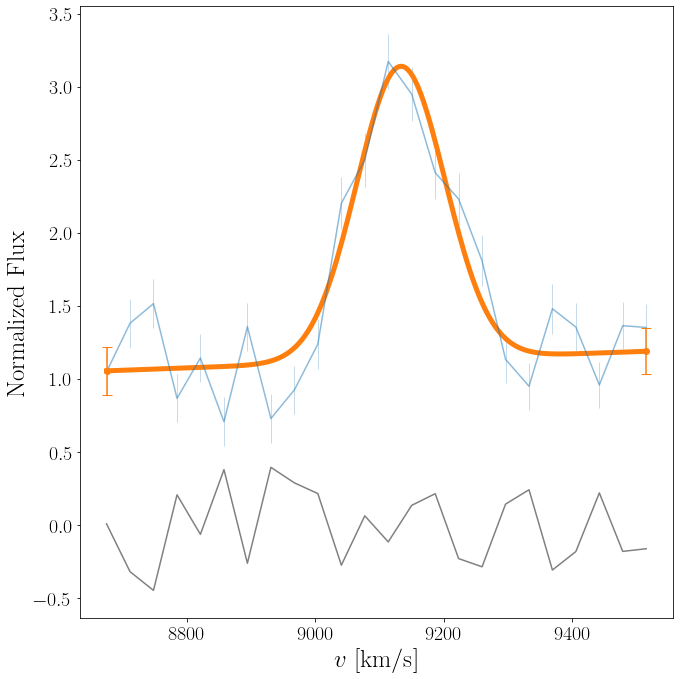

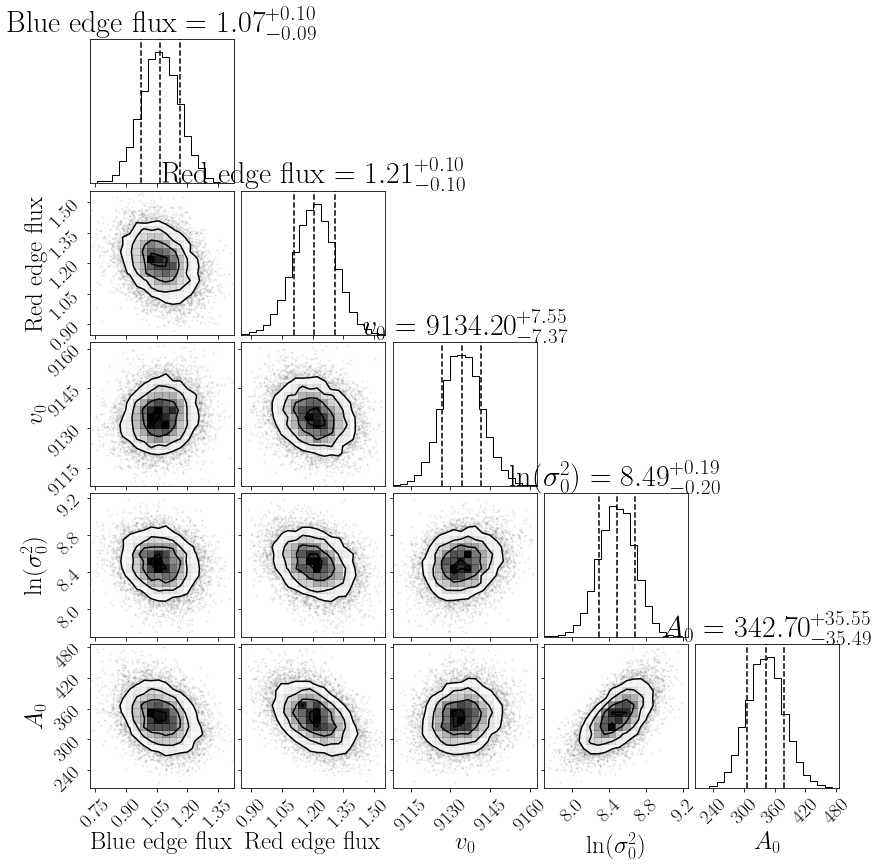

In [35]:
Spec1.line['Oiii'].MCMC_sampler(
    vel_flat=[8500, 9500],
    var_max=1e6,
    initial=[],
    normalize_unc='LS',
    Plot_mcmc=True,
    max_nsteps=20000,
    Plot_tau=False)

In [36]:
Spec1.line['Oiii'].EW, Spec1.line['Oiii'].sig_EW

(-11.18435343458392, 0.9510741115251504)

In [37]:
result = Spec1.line['Oiii'].EW / Spec1.line['Hbeta'].EW
sig = ((Spec1.line['Oiii'].sig_EW / Spec1.line['Oiii'].EW)**2 +
       (Spec1.line['Hbeta'].sig_EW / Spec1.line['Hbeta'].EW)**2) * result
print('lg [Oiii]/Hbeta = {:.2f}+{:.2f}-{:.2f}'.format(
    np.log10(result), np.log10(1 + sig / result), -np.log10(1 - sig / result)))

lg [Oiii]/Hbeta = 0.46+0.06-0.07


## [S ii]

<AxesSubplot:>

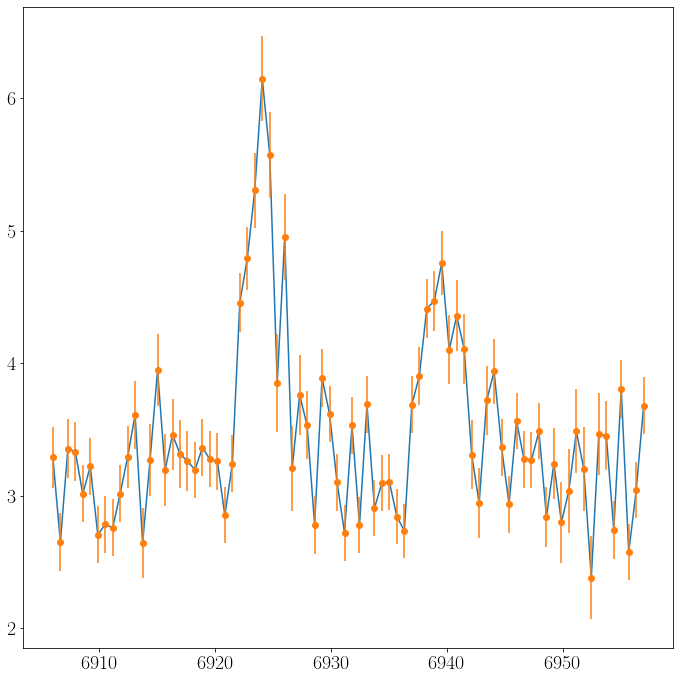

In [38]:
Spec1.plot_line_region(6700*(1+z), 6750*(1+z))

In [39]:
Spec1.add_line('Sii',
               6710*(1+z),
               6740*(1+z),
               lines=[[6716.440, 6730.810]],
               rel_strength=[[2, 1]])
Spec1.line['Sii'].LS_estimator(guess=(1, 1, 9000, 8, 100))

LS estimation:
Velocity 1: 9132 km/s


Normalize factor = 1.554


 15%|█████████████████████████▋                                                                                                                                                 | 3000/20000 [00:21<02:04, 136.95it/s]


MCMC results:
Velocity 1: 9131 pm 6 km/s


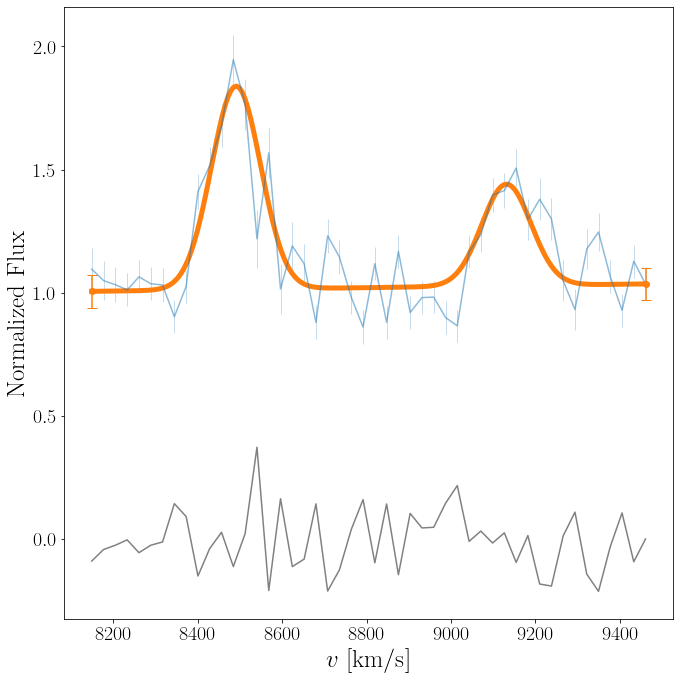

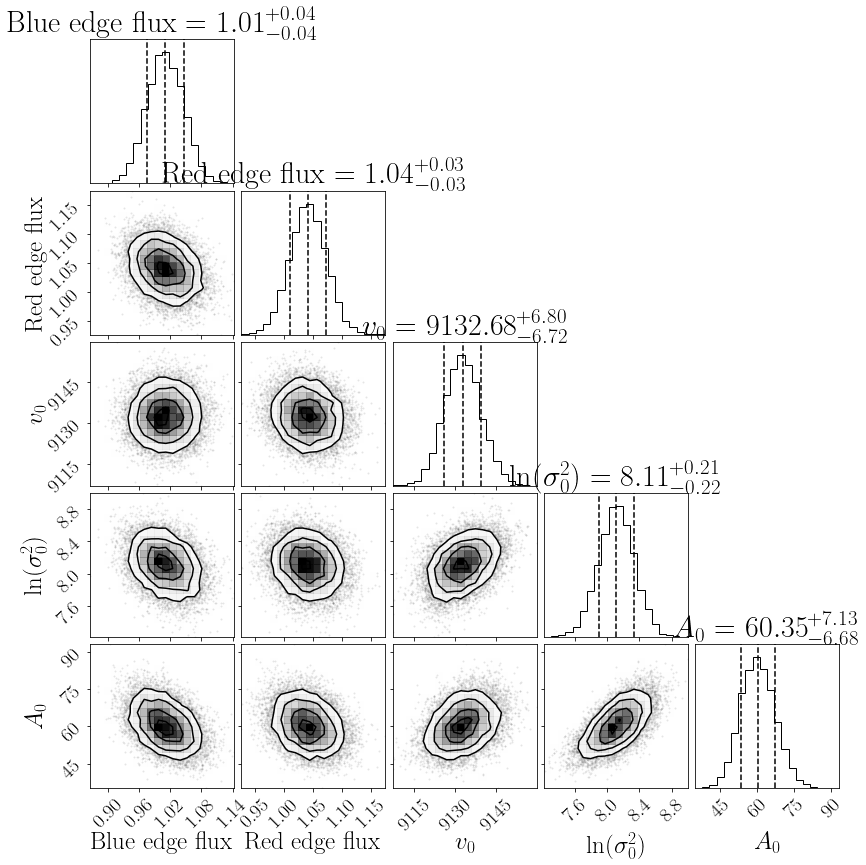

In [40]:
Spec1.line['Sii'].MCMC_sampler(
    vel_flat=[8500, 9500],
    var_max=1e6,
    initial=[],
    normalize_unc='LS',
    Plot_mcmc=True,
    max_nsteps=20000,
    Plot_tau=False)

In [48]:
lines = ['Halpha', 'Hbeta', 'Oiii', 'Nii', 'Sii']
vels = np.array([Spec1.line[line].theta_MCMC[2] for line in lines])
vels_unc = np.array([Spec1.line[line].sig_theta_MCMC[2] for line in lines])

In [49]:
beta, beta_unc = (vels / vels_unc**2).sum() / (1 / vels_unc**2).sum(
) / 299792.458, (1 / (1 / vels_unc**2).sum())**.5 / 299792.458

In [52]:
((1 + beta) / (1 - beta))**.5 - 1

0.03094326279603732